# Understanding KL-Divergence

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

### Goals:



#### G1: Given probability distributions $p$ and $q$, find the divergence (measure of similarity) between them

Let us first look at G1. Look at the illustration below. We have a normal distribution $p$ and two other normal distributions $q_1$ and $q_2$. Which of $q_1$ and $q_2$, would we consider closer to $p$? $q_2$, right? 

![](dkl.png)

To understand the notion of similarity, we use a metric called the KL-divergence given as $D_{KL}(a || b)$ where $a$ and $b$ are the two distributions. 

For G1, we can say $q_2$ is closer to $p$ compared to $q_1$ as:

$D_{KL}(q_2 || p) \lt D_{KL}(q_1 || p)$

For the above example, we have the values as $D_{KL}(q_2|| p) = 0.07$ and $D_{KL}(q_1|| p)= 0.35$

#### G2: assuming $p$ to be fixed, can we find optimum parameters of $q$ to make it as close as possible to $p$

The following GIF shows the process of finding the optimum set of parameters for a normal distribution $q$ so that it becomes as close as possible to $p$. This is equivalent of minimizing $D_{KL}(q || p)$


![](kl_qp.gif)

The following GIF shows the above but for a two-dimensional distribution.


![](kl_qp_2.gif)

### Basic Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tensorflow_probability as tfp
import pandas as pd
tfd = tfp.distributions
tfl = tfp.layers
tfb = tfp.bijectors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback
sns.reset_defaults()
sns.set_context(context='talk',font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Creating distributions

#### Creating $p\sim\mathcal{N}(1.00, 4.00)$

In [2]:
p = tfd.Normal(1, 4)

2022-02-01 11:49:39.192787: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


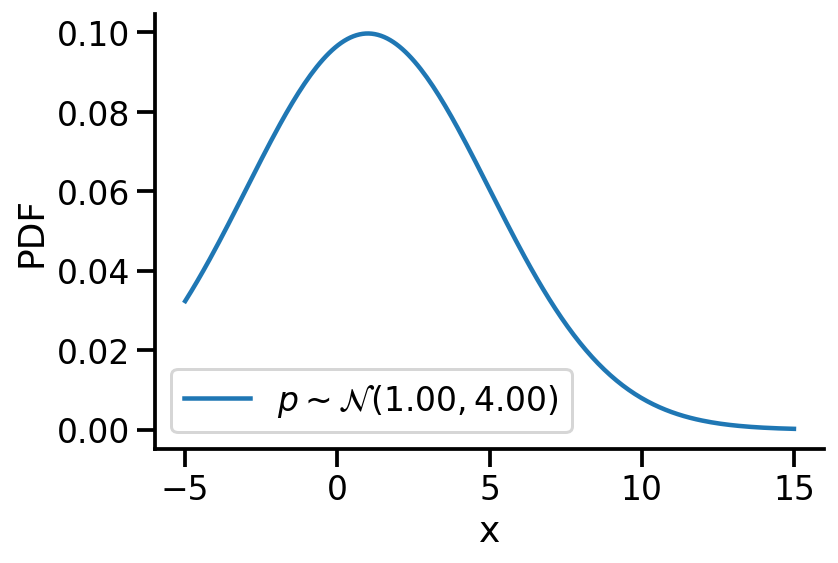

In [3]:
z_values = tf.linspace(-5, 15, 200)
z_values = tf.cast(z_values, tf.float32)
prob_values_p = p.prob(z_values)
plt.plot(z_values, prob_values_p, label=r'$p\sim\mathcal{N}(1.00, 4.00)$')
sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF");

#### Creating $q\sim\mathcal{N}(loc, scale)$

In [4]:
def create_q(loc, scale):
    return tfd.Normal(loc, scale)

#### Generating a few qs for different location and scale value

In [5]:
q =  {}
q[(0, 1)] = create_q(0., 1.)

for loc in [0, 1]:
    for scale in [1, 2]:
        q[(loc, scale)] = create_q(float(loc), float(scale))

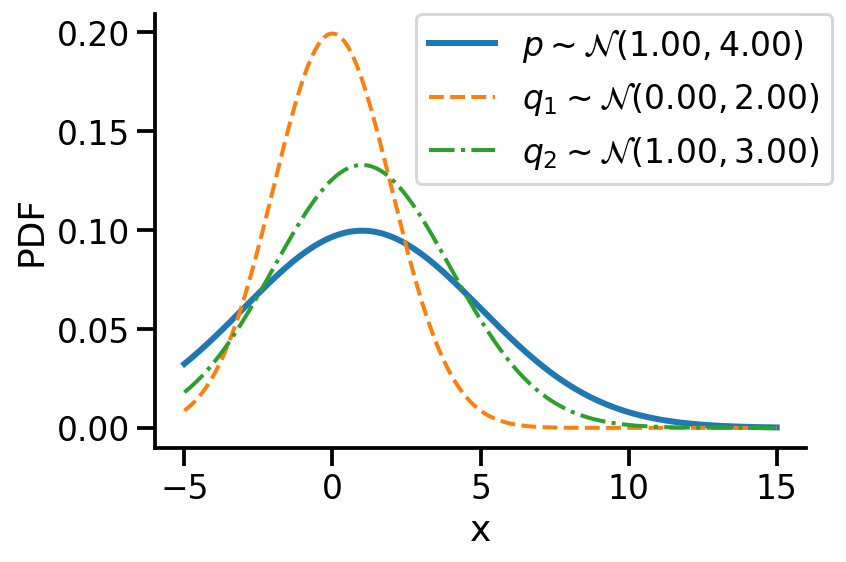

In [6]:
plt.plot(z_values, prob_values_p, label=r'$p\sim\mathcal{N}(1.00, 4.00)$', lw=3)
plt.plot(z_values, create_q(0., 2.).prob(z_values), 
         label=r'$q_1\sim\mathcal{N}(0.00, 2.00)$', lw=2, linestyle='--')
plt.plot(z_values, create_q(1., 3.).prob(z_values),
         label=r'$q_2\sim\mathcal{N}(1.00, 3.00)$', lw=2, linestyle='-.')

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.xlabel("x")
plt.ylabel("PDF")
sns.despine()
plt.tight_layout()
plt.savefig("dkl.png", dpi=200, )

In [7]:
#### Computing KL-divergence

q_0_2_dkl = tfd.kl_divergence(create_q(0., 2.), p)
q_1_3_dkl = tfd.kl_divergence(create_q(1., 3.), p)

print(f"D_KL (q(0, 2)||p) = {q_0_2_dkl:0.2f}")
print(f"D_KL (q(1, 3)||p) = {q_1_3_dkl:0.2f}")

D_KL (q(0, 2)||p) = 0.35
D_KL (q(1, 3)||p) = 0.07


As mentioned earlier, clearly, $q_2\sim\mathcal{N}(1.00, 3.00)$ seems closer to $p$

### Optimizing the KL-divergence between q and p

We could create a grid of (loc, scale) pairs and find the best, as shown below.

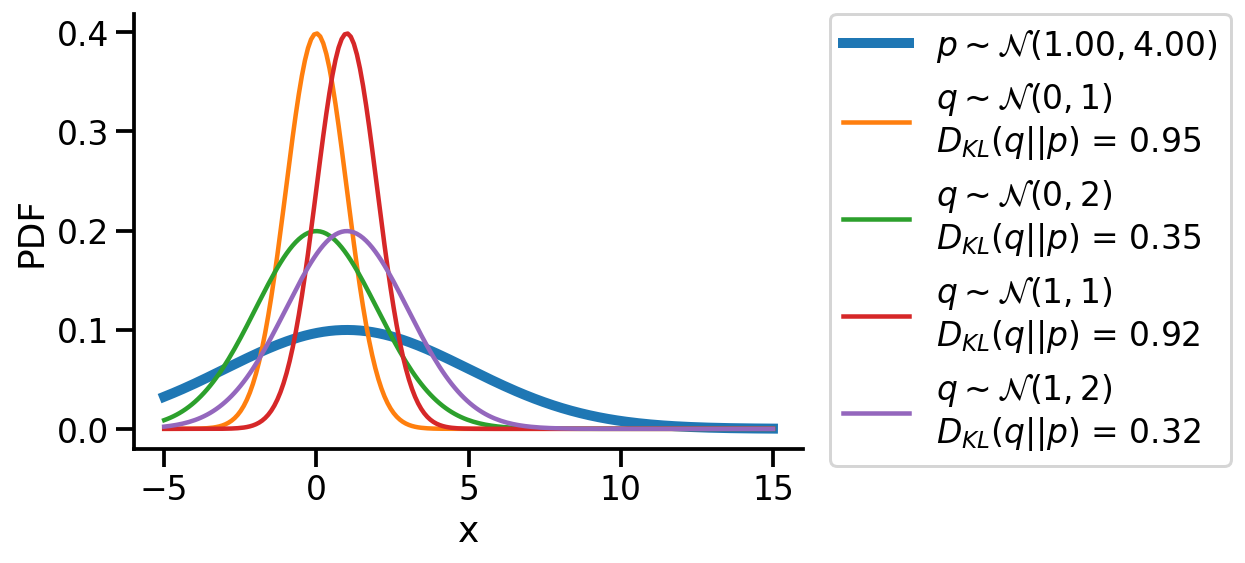

In [8]:
plt.plot(z_values, prob_values_p, label=r'$p\sim\mathcal{N}(1.00, 4.00)$', lw=5)


for loc in [0, 1]:
    for scale in [1, 2]:
        q_d = q[(loc, scale)]
        kl_d = tfd.kl_divergence(q[(loc, scale)], p)
        plt.plot(z_values, q_d.prob(z_values), label = fr'$q\sim\mathcal{{N}}({loc}, {scale})$'
                 +'\n'+rf'$D_{{KL}}(q||p)$ = {kl_d:0.2f}')
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.xlabel("x")
plt.ylabel("PDF")
sns.despine()

Or, we could use continuous optimization to find the best loc and scale parameters for q.

In [9]:
to_train_q = tfd.Normal(loc = tf.Variable(-1., name='loc'),
                        scale = tfp.util.TransformedVariable(1., bijector=tfb.Exp(), name='scale'))

In [10]:
to_train_q.trainable_variables

2022-02-01 11:49:39.978725: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


(<tf.Variable 'loc:0' shape=() dtype=float32, numpy=-1.0>,
 <tf.Variable 'scale:0' shape=() dtype=float32, numpy=0.0>)

In [11]:
@tf.function
def loss_and_grads(q_dist):
    with tf.GradientTape() as tape:
        loss = tfd.kl_divergence(q_dist, p)
    return loss, tape.gradient(loss, q_dist.trainable_variables)

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

for i in range(500):
    loss, grads = loss_and_grads(to_train_q)
    optimizer.apply_gradients(zip(grads, to_train_q.trainable_variables))

In [13]:
to_train_q.loc,to_train_q.scale

(<tf.Variable 'loc:0' shape=() dtype=float32, numpy=0.98873746>,
 <TransformedVariable: name=scale, dtype=float32, shape=[], fn="exp", numpy=3.9999995>)

After training, we are able to recover the scale and loc very close to that of $p$

### Animation!

In [14]:
from matplotlib import animation
fig = plt.figure(tight_layout=True, figsize=(8, 4))
ax = fig.gca()

to_train_q = tfd.Normal(loc = tf.Variable(5., name='loc'),
                        scale = tfp.util.TransformedVariable(0.1, bijector=tfb.Exp(), name='scale'))

def animate(i):
    ax.clear()
    ax.plot(z_values, prob_values_p, label=r'$p\sim\mathcal{N}(1.00, 4.00)$', lw=5)
    loss, grads = loss_and_grads(to_train_q)
    optimizer.apply_gradients(zip(grads, to_train_q.trainable_variables))
    loc = to_train_q.loc.numpy()
    scale = to_train_q.scale.numpy()
    
    ax.plot(z_values, to_train_q.prob(z_values), label=fr"$q\sim \mathcal{{N}}({loc:0.2f}, {scale:0.2f})$")
    d_kl = tfd.kl_divergence(to_train_q, p)
    
    ax.set_title(fr"Iteration: {i}, $D_{{KL}}(q||p)$: {d_kl:0.2f}")
    ax.legend(bbox_to_anchor=(1.1,1), borderaxespad=0)
    ax.set_ylim((0, 1))
    ax.set_xlim((-5, 15))


    ax.set_xlabel("x")
    ax.set_ylabel("PDF")
    sns.despine()
    
ani = animation.FuncAnimation(fig, animate, frames=150)
plt.close()


In [15]:
ani.save('kl_qp.gif', writer='imagemagick', fps=15, dpi=100)

<Figure size 432x288 with 0 Axes>

![](kl_qp.gif)

### Finding the KL divergence for two distributions from different families

Let us rework our example with `p` coming from `Student-T` distribution and `q` being Normal.

In [16]:
p_s = tfd.StudentT(df = 3, loc = 3, scale=5)
p_s

<tfp.distributions.StudentT 'StudentT' batch_shape=[] event_shape=[] dtype=float32>

Let us create two Normal distributions q_1 and q_2 and plot them to see which looks closer to p_s.

In [17]:
q_1 = create_q(3, 1)
q_2 = create_q(3, 4.5)

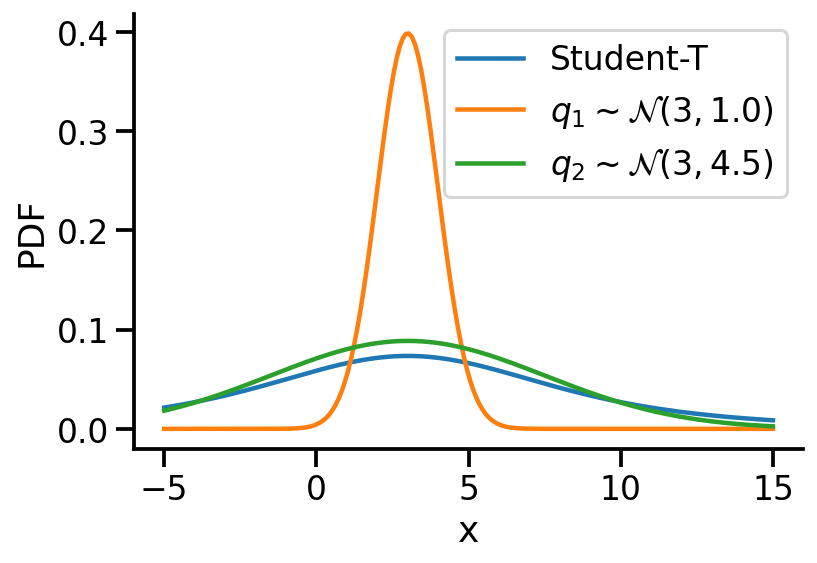

In [18]:
prob_values_p_s = p_s.prob(z_values)
prob_values_q_1 = q_1.prob(z_values)
prob_values_q_2 = q_2.prob(z_values)

plt.plot(z_values, prob_values_p_s, label=r'Student-T')
plt.plot(z_values, prob_values_q_1, label=r'$q_1\sim\mathcal{N} (3, 1.0)$')
plt.plot(z_values, prob_values_q_2, label=r'$q_2\sim\mathcal{N} (3, 4.5)$')

sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF");

![](error-kl.jpg)

As we see above, we can not compute the KL divergence directly.

In [19]:
def kl_via_sampling(q, p, n_samples = 100000):
    # Get samples from q
    sample_set = q.sample(n_samples)
    # Use the definition of KL-divergence
    return tf.reduce_mean(q.log_prob (sample_set) - p.log_prob(sample_set))
    #return tf.reduce_mean(tf.math.log (to_train_q.prob (sample_set) / p_s.prob(sample_set)))

In [20]:
kl_via_sampling(q_1, p_s), kl_via_sampling(q_2, p_s)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.218543>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.09974426>)

As we can see from KL divergence calculations, `q_2`

### Optimizimg the KL-divergence between two 2d distributions

Let us now repeat the same procedure but for two 2d Normal distributions. 

In [21]:
p_2d = tfd.MultivariateNormalFullCovariance(loc=[0., 0.], covariance_matrix=[[1., 0.5],[0.5, 2]])

to_train_q_2d_2 =tfd.MultivariateNormalDiag(loc=tf.Variable([2., -2.], name='loc'),
                                             scale_diag=tfp.util.TransformedVariable([1., 2.],
                                                                                  bijector=tfb.Exp(), 
                                                                                  name='scale'))



Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [22]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


def make_pdf_2d_gaussian(mu, sigma, ax, title):
    N = 60
    X = np.linspace(-3, 3, N)
    Y = np.linspace(-3, 4, N)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    F = tfd.MultivariateNormalFullCovariance(loc=mu, covariance_matrix=sigma)
    Z = F.prob(pos)

    
    sns.despine() 
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_aspect('equal')
    if title:
        ax.set_title(f'$\mu$ = {mu}\n $\Sigma$ = {np.array(sigma)}')
        ax.contour(X, Y, Z, cmap='viridis',alpha=1, zorder=2)
    else:
        ax.contourf(X, Y, Z, cmap='plasma', alpha=0.1)

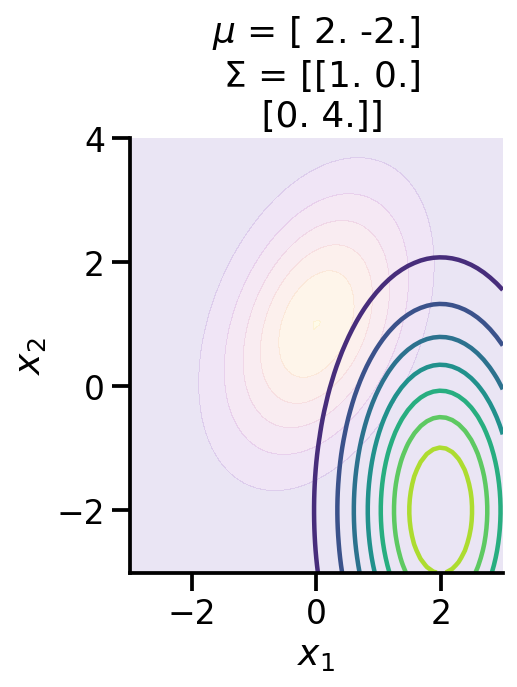

In [23]:
fig, ax = plt.subplots()
make_pdf_2d_gaussian([0., 1.],[[1., 0.5],[0.5, 2]],ax, False)
make_pdf_2d_gaussian(to_train_q_2d_2.loc.numpy(),to_train_q_2d_2.covariance().numpy(), ax, True)

As we can see above, the two distributions look very different. We can calculate the KL-divergence as before.

In [24]:
tfd.kl_divergence(to_train_q_2d_2, p_2d)

<tf.Tensor: shape=(), dtype=float32, numpy=4.8723755>

In [25]:
fig = plt.figure(tight_layout=True, figsize=(8, 4))
ax = fig.gca()

def animate(i):
    ax.clear()
    with tf.GradientTape() as tape:
        loss = tfd.kl_divergence(to_train_q_2d_2, p_2d)
        grads= tape.gradient(loss, to_train_q_2d_2.trainable_variables)
        optimizer.apply_gradients(zip(grads, to_train_q_2d_2.trainable_variables))
    loc = np.round(to_train_q_2d_2.loc.numpy(), 1)
    scale = np.round(to_train_q_2d_2.covariance().numpy(), 1)
        
    make_pdf_2d_gaussian(loc,scale, ax, True)
    make_pdf_2d_gaussian([0., 1.],[[1., 0.5],[0.5, 2]], ax, False)

    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

ani2 = animation.FuncAnimation(fig, animate, frames=100)
plt.close()

In [26]:
ani2.save('kl_qp_2.gif', writer='imagemagick', fps=15, dpi=100)

<Figure size 432x288 with 0 Axes>

In [27]:
to_train_q_2d_2.loc, to_train_q_2d_2.covariance()

(<tf.Variable 'loc:0' shape=(2,) dtype=float32, numpy=array([ 0.03993537, -0.03993573], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.87489367, 0.        ],
        [0.        , 1.7576165 ]], dtype=float32)>)

In [28]:
tfd.kl_divergence(to_train_q_2d_2, p_2d)

<tf.Tensor: shape=(), dtype=float32, numpy=0.068593174>

In [54]:
p_2d = tfd.MultivariateNormalFullCovariance(loc=[0., 0.], covariance_matrix=[[1., 0.5],[0.5, 2]])


x11 = tfp.util.TransformedVariable([1.], bijector=tfb.Exp(), name='x11')[0]
x22 = tfp.util.TransformedVariable([3.], bijector=tfb.Exp(), name='x22') [0]
x12 = tfp.util.TransformedVariable([0.5], bijector=tfb.Exp(), name='x12') [0]


a11  = tf.Variable(1., name='a11')
a12  = tf.Variable(1.)
a22  = tf.Variable(1.)






to_train_q_2d_full =tfd.MultivariateNormalFullCovariance(loc=tf.Variable([2., -2.], name='loc'),
                                             covariance_matrix=tf.Variable([[a11, a12], [a12, a22]], name='cov'))

to_train_q_2d_full_2 =tfd.MultivariateNormalFullCovariance(loc=tf.Variable([2., -2.], name='loc'),
                                             covariance_matrix=tf.Variable([[x11, x12], [x12, x22]], name='cov'))

p_2d = tfd.MultivariateNormalFullCovariance(loc=[0., 0.], covariance_matrix=[[1., 0.5],[0.5, 2]])

to_train_q_final =tfd.MultivariateNormalTriL(loc=tf.Variable([2., -2.], name='loc'),
                                             scale_tril=tfp.util.TransformedVariable([[1., 0.],[0.3, 1.99]],
                                                                                  bijector=tfb.Exp(), 
                                                                                  name='scale'))



2022-02-01 12:05:17.554527: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


In [55]:
tfd.kl_divergence(to_train_q_final, p_2d)

<tf.Tensor: shape=(), dtype=float32, numpy=4.805988>

In [56]:
to_train_q_final.trainable_variables

(<tf.Variable 'loc:0' shape=(2,) dtype=float32, numpy=array([ 2., -2.], dtype=float32)>,
 <tf.Variable 'scale:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.       ,       -inf],
        [-1.2039728,  0.6881347]], dtype=float32)>)

In [57]:
with tf.GradientTape() as tape:
    loss = tfd.kl_divergence(to_train_q_final, p_2d)
    grads= tape.gradient(loss, to_train_q_2d_full_2.trainable_variables)
    #optimizer.apply_gradients(zip(grads, to_train_q_2d_full_2.trainable_variables))
    #loc = np.round(to_train_q_2d_full_2.loc.numpy(), 1)
    #scale = np.round(to_train_q_2d_full_2.covariance().numpy(), 1)
    print(loss)

tf.Tensor(4.805988, shape=(), dtype=float32)


In [58]:
grads

(None, None)

In [50]:
cov = [[2., 0.5], [0.5, 4.]]
tf.linalg.cholesky(cov)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.4142135 , 0.        ],
       [0.35355338, 1.9685019 ]], dtype=float32)>

#### KL-Divergence and ELBO

Let us consider linear regression. We have parameters $\theta \in R^D$ and we define a prior over them. Let us assume we define prior $p(\theta)\sim \mathcal{N_D} (\mu, \Sigma)$. Now, given our dataset $D = \{X, y\}$ and a parameter vector $\theta$, we can deifine our likelihood as $p(D|\theta)$ or $p(y|X, \theta) = \prod_{i=1}^{n} p(y_i|x_i, \theta) = \prod_{i=1}^{n} \mathcal{N}(y_i|x_i^T\theta, \sigma^2) $

As per Bayes rule, we can obtain the posterior over $\theta$ as:

$p(\theta|D) = \dfrac{p(D|\theta)p(\theta)}{p(D)}$

Now, in general $p(D)$ is hard to compute. 

So, in variational inference, our aim is to use a surrogate distribution $q(\theta)$ such that it is very close to $p(\theta|D)$. We do so by minimizing the KL divergence between $q(\theta)$ and $p(\theta|D)$.

Aim: $$q^*(\theta) = \underset{q(\theta) \in \mathcal{Q}}{\mathrm{argmin~}} D_{KL}[q(\theta)||p(\theta|D)]$$

Now,  $$D_{KL}[q(\theta)||p(\theta|D)] = \mathbb{E}_{q(\theta)}[\log\frac{q(\theta)}{p(\theta|D)}]$$
Now,  $$ = \mathbb{E}_{q(\theta)}[\log\frac{q(\theta)p(D)}{p(\theta, D)}]$$
Now,  $$ = \mathbb{E}_{q(\theta)}[\log q(\theta)]- \mathbb{E}_{q(\theta)}[\log p(\theta, D)] + \mathbb{E}_{q(\theta)}[\log p(D)] $$
$$= \mathbb{E}_{q(\theta)}[\log q(\theta)]- \mathbb{E}_{q(\theta)}[\log p(\theta, D)] + \log p(D) $$

Now, $p(D) \in \{0, 1\}$. Thus, $\log p(D) \in \{-\infty, 0 \}$

Now, let us look at the quantities:

$$\underbrace{D_{KL}[q(\theta)||p(\theta|D)]}_{\geq 0} = \underbrace{\mathbb{E}_{q(\theta)}[\log q(\theta)]- \mathbb{E}_{q(\theta)}[\log p(\theta, D)]}_{-\text{ELBO(q)}} +  \underbrace{\log p(D)}_{\leq 0}$$

Thus, we know that $\log p(D) \geq \text{ELBO(q)}$

Thus, finally we can rewrite the optimisation from

$$q^*(\theta) = \underset{q(\theta) \in \mathcal{Q}}{\mathrm{argmin~}} D_{KL}[q(\theta)||p(\theta|D)]$$

to

$$q^*(\theta) = \underset{q(\theta) \in \mathcal{Q}}{\mathrm{argmax~}} \text{ELBO(q)}$$



In [52]:
tfd.MultivariateNormalTriL(loc=[0., 0.], scale_tril=tf.linalg.cholesky(cov)).covariance()

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.9999999 , 0.49999997],
       [0.49999997, 3.9999998 ]], dtype=float32)>

In [59]:
theta = tfd.Normal(loc=0., scale=1.)

In [73]:

prior_samples = theta.sample(100).numpy()
x_values = tf.linspace(-5, 5, 200)
x_values = tf.cast(x_values, tf.float32)


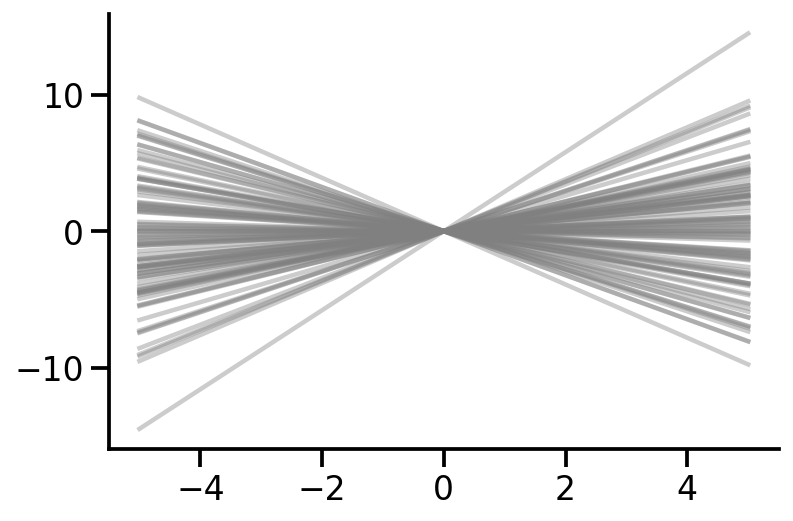

In [74]:
plt.plot(x_values, (prior_samples[..., np.newaxis]*x_values).numpy().T, alpha=0.4, color='grey');
sns.despine()

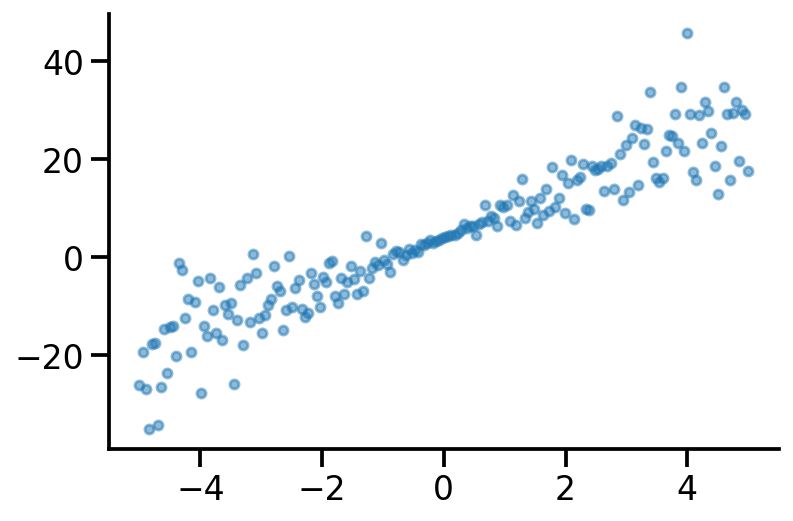

In [83]:
np.random.seed(42)
y_gt = 5*x_values + 4 + 2*np.multiply(x_values, np.random.randn(200))
plt.scatter(x_values, y_gt, s=20, alpha=0.5)
sns.despine()

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback
model_2 = Sequential([
    Dense(input_shape=(1,), units=1, name='M2_D1'),
    tfl.DistributionLambda(lambda loc: tfd.Normal(loc=loc, scale=1.), name='M2_Likelihood')])

def nll(y_true, y_pred):
    # y_pred is distribution
    return -y_pred.log_prob(y_true)

model_2.compile(loss=nll, optimizer='adam')
model_2.fit(x_values, y_gt, epochs=4000, verbose=0)

In [147]:
l = model_2.layers[1]

In [152]:
m = model_2.layers[1]

In [157]:
layer = tfp.layers.DistributionLambda(lambda t: tfd.Normal(t, 1.))
distribution = layer(2.)
distribution.scale

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [122]:
def lik(theta, x):
    return tfd.MultivariateNormalDiag(loc= x*theta, scale_diag=tf.ones_like(x))

In [124]:
l = lik(prior_samples[0], x_values)

In [135]:
l.log_prob(x_values)

<tf.Tensor: shape=(), dtype=float32, numpy=-4985.2>

In [130]:
o = tfd.MultivariateNormalDiag(loc = [1., 2.], scale_diag=[1.,2.])

In [136]:
o.log_prob([2., 3.])

<tf.Tensor: shape=(), dtype=float32, numpy=-3.1560242>

In [141]:
s = tfd.Normal(loc=1., scale=1.)

In [142]:
s.sample(1)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8481398], dtype=float32)>

In [146]:
l_set = lik(sample_set, x_values[..., np.newaxis])

ValueError: Event size of `scale` (1) could not be broadcast up to that of `loc` (10).

In [158]:
def n(theta, x):
    return theta*x

In [159]:
likelihood = tfp.layers.DistributionLambda(lambda theta, x: tfd.MultivariateNormalDiag(theta*x, 1.))

In [162]:
likelihood(theta = 0., x = x_values)

TypeError: __call__() missing 1 required positional argument: 'inputs'

In [179]:
likelihood = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[0], scale=t[1]))

In [183]:
likelihood(inputs=([0.], [9.])).scale

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([9.], dtype=float32)>

In [ ]:
likelihood = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[0], scale=t[1]))

In [143]:
n_samples = 10
sample_set = s.sample(n_samples)
tf.reduce_mean(s.log_prob (sample_set) - theta.log_prob(sample_set)-)


<tf.Tensor: shape=(), dtype=float32, numpy=0.34656098>

We can now see that the KL-divergence has reduced significantly from where we started, but it will unlikely improve as ou
r `q` distribution is a multivariate diagonal normal distribution, meaning there is no correlation between the two dimensions. 

References


- https://www.youtube.com/watch?v=HUsznqt2V5I
- https://www.youtube.com/watch?v=x9StQ8RZ0ag&list=PLISXH-iEM4JlFsAp7trKCWyxeO3M70QyJ&index=9
- https://colab.research.google.com/github/goodboychan/goodboychan.github.io/blob/main/_notebooks/2021-09-13-02-Minimizing-KL-Divergence.ipynb#scrollTo=gd_ev8ceII8q
- https://goodboychan.github.io/python/coursera/tensorflow_probability/icl/2021/09/13/02-Minimizing-KL-Divergence.html
